In [1]:
import cv2
import json
from src.lib.utils.pnp.cuboid_pnp_shell import pnp_shell
import matplotlib.pyplot as plt
import numpy as np
from src.lib.opts import opts
from itertools import permutations
import copy
import math
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [2]:
# OPT:
opt = opts()
opt.nms = True
opt.obj_scale = True
opt.c = "cereal_box" # category
    
# Meta: 
# camera = np.array([[3327.58, 0, 2592], [0, 4164.18, 1944], [0, 0, 1]], dtype=np.float32)
# Load data from the PKL file
with open('cameraMatrix.pkl', 'rb') as f:
    camera = pickle.load(f)
# camera = np.array([[3648, 0, 2736], [0, 3648, 1824], [0, 0, 1]], dtype=np.float32)
print("Camera: \n", camera)

Camera: 
 [[3.67253815e+03 0.00000000e+00 2.51466465e+03]
 [0.00000000e+00 3.79219835e+03 1.88693480e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [3]:
# Take GT as imput:
with open('data/synthetic_data/test/anno.json', 'r') as f:
    data = json.load(f)

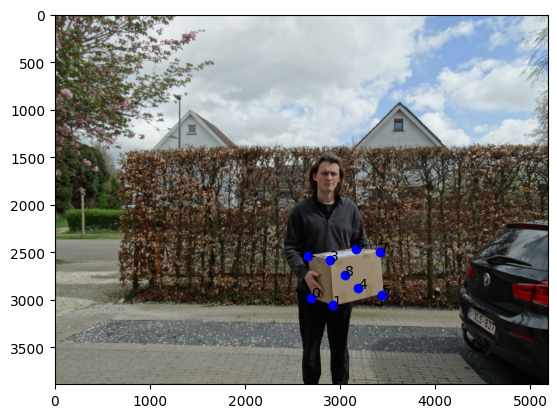

In [4]:
# first test with GT cereal:
img_id = 0
img_gt = data[img_id]
size = img_gt["whd"]
points =  img_gt["projection"]
w_points = img_gt["world"]

image = plt.imread("data/synthetic_data/test/" + str(img_id) + ".jpg")
plt.imshow(image)

for i, p in enumerate(points):
     plt.plot(p[0],p[1], 'bo')
     plt.text(p[0], p[1], f"{i}")

plt.show()

In [5]:
bbox = {'kps': points[:8], "obj_scale": size}
print("width", image.shape[1],"height", image.shape[0])
meta = {"width": image.shape[1],"height": image.shape[0], "camera_matrix": camera}
print("size: ", size)

width 5184 height 3888
size:  [1.4074075244934912, 1.0, 0.9444445279955664]


In [6]:
projected_points, point_3d_cam, scale, points_ori, bbox = pnp_shell(opt, meta, bbox, points[:8], size, OPENCV_RETURN=False)
gt_wc = bbox["kps_3d_cam"]

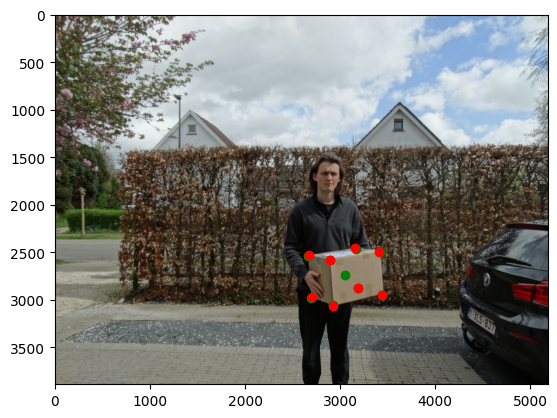

In [7]:
# pprint(bbox)
plt.imshow(image)

# GT
for p in points:
     plt.plot(int(p[0]),int(p[1]), 'go')

# After PnP  
for p in bbox["projected_cuboid"]:
     plt.plot(int(p[0]),int(p[1]), 'ro')


plt.show()

In [8]:
# Provided data with invalid points
points = np.array([
    [2654.7003479, 3000.43257523], [-10000., -10000.],
    [2838.25923157, 3080.96229172], [-10000., -10000.],
    [2611.60451889, 2462.59077072], [-10000., -10000.],
    [2806.37265015, 2460.38828659], [-10000., -10000.],
    [3236.37708664, 2931.2752533], [-10000., -10000.],
    [3476.56712723, 3012.95843124], [-10000., -10000.],
    [3116.66243362, 2409.68542099], [-10000., -10000.],
    [3321.2855072, 2415.07390594], [-10000., -10000.]
], dtype=np.float32)


# Filter out invalid points
# valid_points = points[points[:, 0] != -10000]

size = [0.9709629, 0.9928523, 1.0862362]

# Example 3D world
bbox = {'kps': points, "obj_scale": size}
meta = {"width": image.shape[1],"height": image.shape[0], "camera_matrix": camera}
projected_points, point_3d_cam, scale, points_ori, bbox = pnp_shell(opt, meta, bbox, points, size, OPENCV_RETURN=False)

print(bbox["projected_cuboid"])


[[2695.88791263 3013.67317179]
 [2859.12328695 3107.30196276]
 [2635.69128797 2457.51685271]
 [2784.34287421 2449.51784717]
 [3188.06035732 2940.91638438]
 [3433.06514335 3018.58252649]
 [3120.00829507 2401.41248094]
 [3347.68641452 2383.96231885]]


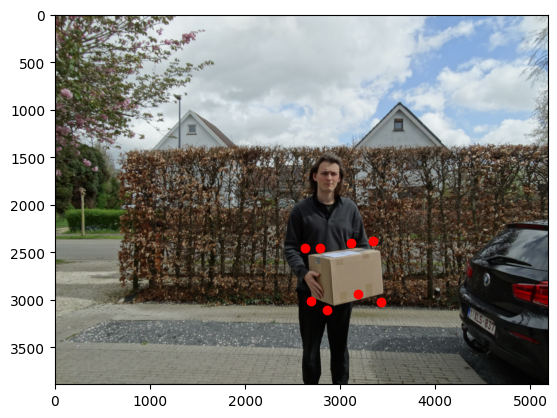

In [9]:
plt.imshow(image)

# After PnP  
for p in bbox["projected_cuboid"]:
     plt.plot(int(p[0]),int(p[1]), 'ro')
plt.show()

In [10]:
pred_wc = bbox["kps_3d_cam"]

In [11]:
# Separate the list of points into individual lists for x, y, and z coordinates
gt_wc = gt_wc[1:]
x_coords_set1 = [point[0] for point in gt_wc]
y_coords_set1 = [point[1] for point in gt_wc]
z_coords_set1 = [point[2] for point in gt_wc]

pred_wc = pred_wc[1:]
x_coords_set2 = [point[0] for point in pred_wc]
y_coords_set2 = [point[1] for point in pred_wc]
z_coords_set2 = [point[2] for point in pred_wc]

# Create the 3D scatter plot for the first set of points
trace_set1 = go.Scatter3d(
    x=x_coords_set1,
    y=y_coords_set1,
    z=z_coords_set1,
    mode='markers+text',
    marker=dict(size=8, color='blue', opacity=0.8),
    text=[str(i) for i in range(len(gt_wc))],
    textposition='top center',
    name='Set 1'
)

# Create the 3D scatter plot for the second set of points
trace_set2 = go.Scatter3d(
    x=x_coords_set2,
    y=y_coords_set2,
    z=z_coords_set2,
    mode='markers+text',
    marker=dict(size=8, color='red', opacity=0.8),
    text=[str(i) for i in range(len(gt_wc))],
    textposition='top center',
    name='Set 2'
)

# Set up the layout
layout = go.Layout(
    title='3D Scatter Plot of Points (Plotly)',
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
         camera=dict(
            eye=dict(x=0, y=0, z=-15),  # Equivalent to the eye in gluLookAt
            center=dict(x=0, y=0, z=0),  # Point to look at
            up=dict(x=0, y=1, z=0)  # Up direction
        )
    )
)

# Create the figure and specify the renderer
fig = go.Figure(data=[trace_set1, trace_set2], layout=layout)
fig.show(renderer="browser")


In [12]:
points_translated = [
    [2.51559579, 0.71440579, -8.83129927],
    [2.34347553, 0.91959567, -7.77053018],
    [1.53116988, 0.60662441, -8.97018341],
    [1.35904962, 0.81181429, -7.90941432],
    [2.43887107, 1.66920467, -9.02844015],
    [2.26675081, 1.87439455, -7.96767106],
    [1.45444516, 1.56142328, -9.16732429],
    [1.2823249, 1.76661317, -8.1065552]
]

# Convert to NumPy array for convenience
points_translated = np.array(points_translated)

In [13]:
# Separate the list of points into individual lists for x, y, and z coordinates
x_coords_set1 = [point[0] for point in gt_wc]
y_coords_set1 = [point[1] for point in gt_wc]
z_coords_set1 = [point[2] for point in gt_wc]

x_coords_set2 = [point[0] for point in points_translated]
y_coords_set2 = [point[1] for point in points_translated]
z_coords_set2 = [point[2] for point in points_translated]

# Create the 3D scatter plot for the first set of points
trace_set1 = go.Scatter3d(
    x=x_coords_set1,
    y=y_coords_set1,
    z=z_coords_set1,
    mode='markers+text',
    marker=dict(size=8, color='blue', opacity=0.8),
    text=[str(i) for i in range(len(gt_wc))],
    textposition='top center',
    name='Set 1'
)

# Create the 3D scatter plot for the second set of points
trace_set2 = go.Scatter3d(
    x=x_coords_set2,
    y=y_coords_set2,
    z=z_coords_set2,
    mode='markers+text',
    marker=dict(size=8, color='red', opacity=0.8),
    text=[str(i) for i in range(len(gt_wc))],
    textposition='top center',
    name='Set 2'
)

# Set up the layout
layout = go.Layout(
    title='3D Scatter Plot of Points (Plotly)',
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
         camera=dict(
            eye=dict(x=0, y=0, z=-15),  # Equivalent to the eye in gluLookAt
            center=dict(x=0, y=0, z=0),  # Point to look at
            up=dict(x=0, y=1, z=0)  # Up direction
        )
    )
)

# Create the figure and specify the renderer
fig = go.Figure(data=[trace_set1, trace_set2], layout=layout)
fig.show(renderer="browser")
